# Image Captioning with Bimodal Transformers

In this notebook we are going to be using COCO captioned image data to build a model that produces natural language descriptions of given images.

We will be using a InceptionV3 convolutional neural network pretrained on classifying imagenet images and an ALBERT transformer network pretrained on a general language modelling task.

We will construct the bimodal transformer to aggregate image and language information. The following is an outline of the model architecture:

<img src="bmt_architecture.png" width="600">

In [3]:
from datetime import datetime 
from functools import partial
from itertools import chain, cycle
import json
import multiprocessing
import os
from pathlib import Path
import time
from typing import Tuple, List

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import tensorflow as tf
import transformers

print('Physical Devices:\n', tf.config.list_physical_devices(), '\n')
%load_ext tensorboard

DATASETS_PATH = os.environ['DATASETS_PATH']
MSCOCO_PATH = f'{DATASETS_PATH}/MSCOCO_2017'
COCO_VERSION = 'val2017'
LOAD_COCO_PREPROC_CACHE_IF_EXISTS = True

PRETRAINED_TRANSFORMER_VERSION = 'albert-base-v2'
Transformer = transformers.TFAlbertModel
Tokenizer = transformers.AlbertTokenizer
MLMHead = transformers.modeling_tf_albert.TFAlbertMLMHead

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
OUTPUTS_DIR = f'./outputs/{stamp}'
print('\nOutput Directory:', OUTPUTS_DIR)

Physical Devices:
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard

Output Directory: ./outputs/20200424-000059


In [4]:
log_dir = f'{OUTPUTS_DIR}/logs'
summary_writer = tf.summary.create_file_writer(log_dir)
tf.summary.trace_on(graph=True) 
print(log_dir)

./outputs/20200424-000059/logs


## Loading COCO

Firstly, we are going to load the COCO data. For the sakes of this demonstration I am running this on my limited machine, as such we will only load in the 5000 validation samples. 

In [5]:
captions_path = f'{MSCOCO_PATH}/annotations/captions_{COCO_VERSION}.json'
coco_captions = json.loads(Path(captions_path).read_text())
coco_captions = {
    item['image_id']: item['caption']
    for item in coco_captions['annotations']
}

In [6]:
images_path = f'{MSCOCO_PATH}/{COCO_VERSION}'
image_paths = Path(images_path).glob('*.jpg')
coco_imgs = {
    int(path.name.split('.')[0]): cv2.imread(str(path))
    for path in image_paths
}

In [7]:
coco_data: List[Tuple[np.ndarray, str]] = [
    (img_id, coco_imgs[img_id], coco_captions[img_id])
    for img_id in coco_imgs
    if img_id in coco_captions
]

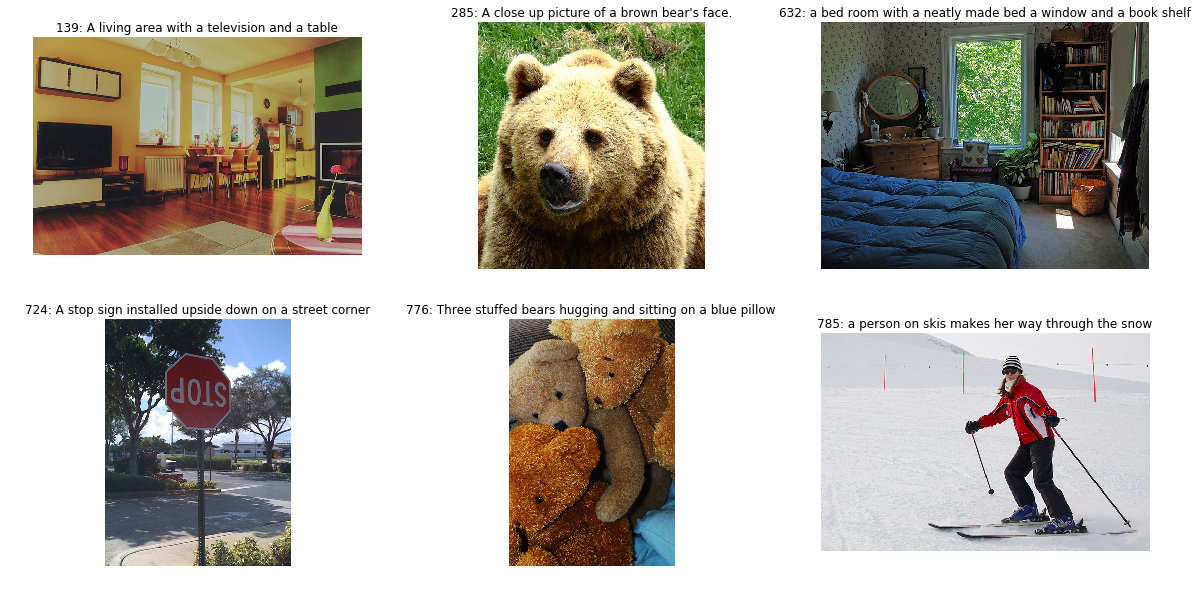

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, ax in enumerate(chain(list(axs.flatten()))):
    img_id, img, cap = coco_data[i]
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(f'{img_id}: {cap}')
    ax.axis('off')
plt.show()

## Preprocessing the Data

In order to reduce the amount of learning that our model needs to do we are using the pretrained InceptionV3 model. To do this we will pass each of our images through InceptionV3 and extract the activations in the penultimate layers. These extracted tensors are our "image embeddings" and they capture the semantic content of the input in a ready-to-use state for downstream tasks. 

Additionally, our transformer network, ALBERT, only ingests sentences that have been tokenized. As such, we extract "caption encodings" using the tokenizer. This replaces (approximate) morphemes in the sentence with assigned identifiers. 

Once we have preprocessed the data we will store it in a cache for retrieval in the future. Additionally this helps relieve memory limitations as we can now discard the InceptionV3 model for the training phase. In order to keep track of the information in the cache we will also store the COCO image identifier (IID). 

In [9]:
def inceptionv3_preprocess(img, img_size=(128, 129)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    return tf.keras.applications.inception_v3.preprocess_input(img)

In [10]:
def create_image_features_extract_model():
    image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                    weights='imagenet')
    new_input = image_model.input
    hidden_layer = image_model.layers[-1].output
    return tf.keras.Model(new_input, hidden_layer)

In [11]:
tokenizer = Tokenizer.from_pretrained(PRETRAINED_TRANSFORMER_VERSION)

In [12]:
print('Vocab size:', tokenizer.vocab_size)
for (name, token), iden in zip(tokenizer.special_tokens_map.items(), 
                               tokenizer.all_special_ids):
    print(f'{name}: {token}, ID: {iden}')
print()
print('Input:', cap)
print('Encoded:', tokenizer.encode(cap))

Vocab size: 30000
bos_token: [CLS], ID: 2
eos_token: [SEP], ID: 3
unk_token: <unk>, ID: 0
sep_token: [SEP], ID: 4
pad_token: <pad>, ID: 1

Input: a person on skis makes her way through the snow
Encoded: [2, 21, 840, 27, 7185, 18, 1364, 36, 161, 120, 14, 2224, 3]


In [13]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def coco_preprocess_batch(coco_batch: list, 
                          image_feature_extract_model: tf.keras.Model,
                          tokenizer: Tokenizer):
    iids = [iid for iid, _, _ in coco_batch]
    imgs = [img for _, img, _ in coco_batch]
    caps = [cap for _, _, cap in coco_batch]
    
    cap_encodings = [tokenizer.encode(cap) for cap in caps]
    x = np.array([inceptionv3_preprocess(img) for img in imgs])
    img_embeddings = image_feature_extract_model(x)
    return list(zip(iids, img_embeddings, cap_encodings))

def make_coco_preprocessed(tokenizer: Tokenizer,
                           batch_size=4):
    image_feature_extract_model = create_image_features_extract_model()
    return [
        record
        for coco_batch in batch(coco_data, batch_size)
        for record in coco_preprocess_batch(coco_batch,
                                            image_feature_extract_model,
                                            tokenizer)
    ]

Tensorflow does not have a built-in way to release a model from memory so we have to spin-up a concurrent process using `multiprocess` that does the preprocessing. When this process terminates it will clear the memory.

In [14]:
preprocessed_coco_cache_dir = Path(f'{MSCOCO_PATH}/inception-{PRETRAINED_TRANSFORMER_VERSION}-preprocessed')
preprocessed_coco_cache_dir.mkdir(exist_ok=True)
preprocessed_coco_cache_path = preprocessed_coco_cache_dir / f'{COCO_VERSION}.npy'
if preprocessed_coco_cache_path.exists():
    print('Loading cached preprocessed data...')
    coco_preprocessed = list(np.load(preprocessed_coco_cache_path, 
                                     allow_pickle=True))
    coco_preprocessed = [tuple(x) for x in coco_preprocessed]
else:
    print('Preprocessing and creating cache...')
    def preprocess_and_cache():
        coco_preprocessed = make_coco_preprocessed(tokenizer)
        np.save(preprocessed_coco_cache_path, np.array(coco_preprocessed))
    
    # Using multiprocess to clear Inception GPU usage when process terminates
    p = multiprocessing.Process(target=preprocess_and_cache)
    p.start()
    p.join()

Loading cached preprocessed data...


In [15]:
coco_preprocessed[0]

(139,
 <tf.Tensor: shape=(2, 2, 2048), dtype=float32, numpy=
 array([[[2.5995767 , 0.        , 0.4370903 , ..., 0.7036782 ,
          1.0261441 , 3.478441  ],
         [3.5346863 , 0.        , 0.48941162, ..., 0.7036782 ,
          1.0261441 , 3.478441  ]],
 
        [[1.6772687 , 0.        , 2.2373395 , ..., 0.7036782 ,
          1.0261441 , 3.478441  ],
         [1.7453028 , 0.        , 0.43314373, ..., 0.7036782 ,
          1.0261441 , 3.478441  ]]], dtype=float32)>,
 [2, 21, 634, 217, 29, 21, 633, 17, 21, 859, 3])

## Creating Train-Test Datasets

In order to train our model we will create train and test datasets from our preprocessed data. The training data will be organised in batches where sequences of varying lengths are collected into matrices. The matrices are filled by padding the shorter sequences with a special token defined by the tokenizer. Later the transformer will be instructed to not pay attention to these padding tokens.

In [16]:
coco_train_data, coco_test_data = train_test_split(coco_preprocessed, test_size=0.2)
outputs = (tf.int32, tf.float32, tf.int32) 

BUFFER_SIZE = 10000
BATCH_SIZE = 8

coco_train = tf.data.Dataset.from_generator(lambda: cycle(coco_train_data), outputs)

# example sample to define the padding shapes
iid_ex, img_emb_ex, cap_enc_ex = next(iter(coco_train))

coco_train = coco_train.shuffle(BUFFER_SIZE)
coco_train = coco_train.padded_batch(
    BATCH_SIZE, 
    padded_shapes=(iid_ex.shape, img_emb_ex.shape, [None]), 
    padding_values=(0, 0.0, tokenizer.pad_token_id)
)

coco_test = tf.data.Dataset.from_generator(lambda: cycle(coco_test_data), outputs)

In [17]:
coco_train

<PaddedBatchDataset shapes: ((None,), (None, 2, 2, 2048), (None, None)), types: (tf.int32, tf.float32, tf.int32)>

## Masked Language Modelling

In order to train the caption generator we will learn through a masked language modelling (MLM) scheme. This involves arbitrarily removing tokens in a caption and having the model reconstruct the input. This process is inspired by the [Cloze deletion test](https://en.wikipedia.org/wiki/Cloze_test) from psychology. MLM was introducted by the authors of BERT.

In [18]:
def create_mask_and_input(tar: tf.Tensor, 
                          tokenizer: Tokenizer,
                          prob_mask=0.15,
                          seed=None) -> tf.Tensor:
    """
    prob_mask hyperparams from: https://arxiv.org/pdf/1810.04805.pdf
    """
    if seed is not None:
        tf.random.set_seed(seed)
        
    where_masked = tf.random.uniform(tar.shape) < prob_mask
    for special_token in tokenizer.all_special_ids:
        where_masked &= tar != special_token
    
    mask_tokens = tf.multiply(tokenizer.mask_token_id, 
                              tf.cast(where_masked, tf.int32))
    not_masked = tf.multiply(tar, 1 - tf.cast(where_masked, tf.int32))
    inp = mask_tokens + not_masked
    
    return inp, where_masked

In [20]:
iid, img_emb, cap_enc = next(iter(coco_train))
train_cap_enc, where_masked = create_mask_and_input(cap_enc, tokenizer)
for i in range(3):
    print(f'Batch Item {i}:')
    print(tokenizer.decode(train_cap_enc[i].numpy()))
    print(tokenizer.decode(cap_enc[i].numpy()))
    print()

Batch Item 0:
[CLS][MASK] girls share a bite of pizza clowning for the camera.[SEP]<pad><pad><pad><pad>
[CLS] three girls share a bite of pizza clowning for the camera.[SEP]<pad><pad><pad><pad>

Batch Item 1:
[CLS] a bathroom done in almost total white[SEP]<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
[CLS] a bathroom done in almost total white[SEP]<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

Batch Item 2:
[CLS] a[MASK] rider competing in an obstacle course event.[SEP]<pad><pad><pad><pad><pad><pad><pad>
[CLS] a horseback rider competing in an obstacle course event.[SEP]<pad><pad><pad><pad><pad><pad><pad>



## Defining the Model Architecture

<img src="bmt_architecture.png" width="600">

In [21]:
class BimodalMLMTransformer(tf.keras.Model):
    
    def __init__(self, transformer: Transformer, **kwargs):
        super().__init__(**kwargs)
        
        self.transformer = transformer
        self.predictions  = MLMHead(transformer.config, 
                                    transformer.albert.embeddings,
                                    name='predictions')
    
    def call(self, 
             inputs: tf.Tensor, 
             **transformer_kwargs):
        
        img_embs, cap_encs = inputs
        
        outputs = self.transformer(cap_encs, **transformer_kwargs)
        last_hidden_state, *_ = outputs
        batch_size, batch_seq_len, last_hidden_dim = last_hidden_state.shape

        # reshape and repeat image embeddings
        batch_size, *img_emb_shape = img_embs.shape
        img_emb_flattened = tf.reshape(img_embs, (batch_size, np.prod(img_emb_shape)))
        emb_flattened_reps = tf.repeat(tf.expand_dims(img_emb_flattened, 1), 
                                       batch_seq_len, axis=1)
        
        # concatenate the language and image embeddings
        embs_concat = tf.concat([last_hidden_state, emb_flattened_reps], 2)
        
        # generate mlm predictions over input sequence
        training = transformer_kwargs.get('training', False)
        prediction_scores = self.predictions(embs_concat, training=training)

        # Add hidden states and attention if they are here
        outputs = (prediction_scores,) + outputs[2:]

        return outputs

In [31]:
transformer = Transformer.from_pretrained(PRETRAINED_TRANSFORMER_VERSION)
transformer.trainable = False

In [32]:
bm_transformer = BimodalMLMTransformer(transformer)

In [38]:
bm_transformer.summary()

Model: "bimodal_mlm_transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_albert_model_1 (TFAlbertM multiple                  11683584  
_________________________________________________________________
predictions (TFAlbertMLMHead multiple                  5113312   
Total params: 12,890,848
Trainable params: 1,207,264
Non-trainable params: 11,683,584
_________________________________________________________________


In [39]:
iid, img_emb, cap_enc = next(iter(coco_train))
iid, img_emb, cap_enc

(<tf.Tensor: shape=(8,), dtype=int32, numpy=array([230362, 472375, 389532, 160728,  71756, 359937, 394611, 500211])>,
 <tf.Tensor: shape=(8, 2, 2, 2048), dtype=float32, numpy=
 array([[[[8.2812655e-01, 0.0000000e+00, 2.3744605e+00, ...,
           2.6479197e+00, 6.6884130e-02, 0.0000000e+00],
          [1.9108174e+00, 7.6255983e-01, 1.2225776e+00, ...,
           2.6479197e+00, 6.6884130e-02, 0.0000000e+00]],
 
         [[3.3572485e+00, 0.0000000e+00, 5.0006227e+00, ...,
           2.6479197e+00, 6.6884130e-02, 0.0000000e+00],
          [2.5800207e+00, 6.2725401e-01, 2.6019411e+00, ...,
           2.6479197e+00, 6.6884130e-02, 0.0000000e+00]]],
 
 
        [[[2.5249224e+00, 1.4624733e+00, 2.5228009e+00, ...,
           0.0000000e+00, 0.0000000e+00, 1.4165843e-01],
          [9.5054090e-01, 6.7353225e-01, 1.2732261e+00, ...,
           0.0000000e+00, 0.0000000e+00, 1.4165843e-01]],
 
         [[1.6882330e-01, 2.8575425e+00, 2.6694603e+00, ...,
           0.0000000e+00, 0.0000000e+00, 1.

In [40]:
preds, *_ = bm_transformer((img_emb, cap_enc))
preds

<tf.Tensor: shape=(8, 17, 30000), dtype=float32, numpy=
array([[[-0.00255676, -0.28133634,  0.12696652, ...,  0.1115055 ,
          0.34350696,  0.3839145 ],
        [-0.09330822, -0.18555197,  0.01063907, ...,  0.03937093,
          0.41564718,  0.08644014],
        [-0.03865747, -0.10990265,  0.03537906, ...,  0.11738862,
          0.42082825,  0.17752409],
        ...,
        [-0.17437483, -0.23764138,  0.02301986, ...,  0.17670228,
          0.44555935,  0.24811713],
        [-0.06642682, -0.20172231,  0.01112237, ...,  0.07609118,
          0.36903346,  0.18448952],
        [-0.06554484, -0.18087997,  0.11517162, ...,  0.12602535,
          0.29741278,  0.15244102]],

       [[-0.48096776,  0.15347643,  0.08103826, ..., -0.18020293,
         -0.01668783,  0.085361  ],
        [-0.48062724,  0.15324363,  0.08098698, ..., -0.18029806,
         -0.01708161,  0.08533505],
        [-0.48065975,  0.1532947 ,  0.08097532, ..., -0.18026003,
         -0.01703009,  0.08532354],
        ...

In [41]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-08, clipnorm=1.0)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

train_acc = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [36]:
checkpoint_path = f'{OUTPUTS_DIR}/ckpts'

ckpt = tf.train.Checkpoint(transformer=bm_transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [37]:
with summary_writer.as_default():
    tf.summary.trace_export(
      name="bm_transformer",
      step=0, profiler_outdir=log_dir)

Model: "bimodal_mlm_transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_albert_model_1 (TFAlbertM multiple                  11683584  
_________________________________________________________________
predictions (TFAlbertMLMHead multiple                  5113312   
Total params: 12,890,848
Trainable params: 1,207,264
Non-trainable params: 11,683,584
_________________________________________________________________


ValueError: Must enable trace before export.

In [78]:
def train_step(model: tf.keras.Model,
               optimizer: tf.keras.optimizers.Optimizer,
               tokenizer: Tokenizer,
               inp: Tuple):
    
    iids, img_embs, cap_encs = inp
    masked_cap_encs, where_masked = create_mask_and_input(cap_encs, tokenizer)
    
    with tf.GradientTape() as tape:
        attention_mask = tf.cast(masked_cap_encs != tokenizer.pad_token_id, 
                                 tf.int32)
        logits, *_ = model((img_embs, masked_cap_encs), 
                           attention_mask=attention_mask,
                           training=True)
        loss = loss_fn(cap_encs[where_masked], logits[where_masked])

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_acc(cap_encs[where_masked], logits[where_masked])
    train_loss(loss)
    
    return logits, loss


# train_step_signature = [
#     tf.TensorSpec(shape=(BATCH_SIZE, MAX_SEQ_SIZE), 
#                   dtype=tf.int32),
#     tf.TensorSpec(shape=(BATCH_SIZE, MAX_SEQ_SIZE), 
#                   dtype=tf.int32),
# ]


@tf.function
def train_step_tf(inp):
    train_step(bm_transformer, optimizer, tokenizer, inp)

In [79]:
BATCHES_IN_EPOCH = 250
epoch = 0

In [80]:
EPOCHS = 300

In [81]:
try:
    while epoch < EPOCHS:
        start = time.time()

        train_loss.reset_states()
        train_acc.reset_states()

        for batch, inp in enumerate(coco_train):
            train_step_tf(inp)

            if batch % 50 == 0:
                print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                    epoch + 1, batch, train_loss.result(), train_acc.result()))

                with summary_writer.as_default():
                    tf.summary.scalar('loss', train_loss.result(), 
                                      step=epoch)
                    tf.summary.scalar('accuracy', train_acc.result(), 
                                      step=epoch)

            if batch >= BATCHES_IN_EPOCH:
                break

        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                                 ckpt_save_path))

        print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                             train_loss.result(), 
                                                             train_acc.result()))

        print ('Time taken for epoch: {} secs\n'.format(time.time() - start))
        epoch += 1
        
except KeyboardInterrupt:
    print('Manual interrupt')

Epoch 1 Loss 8.5700 Accuracy 0.1241
Time taken for epoch: 212.10938668251038 secs

Epoch 2 Loss 8.5289 Accuracy 0.1365
Time taken for epoch: 32.14652180671692 secs

Epoch 3 Loss 8.4865 Accuracy 0.1351
Time taken for epoch: 31.461716651916504 secs

Epoch 4 Loss 8.4061 Accuracy 0.1461
Time taken for epoch: 31.625213623046875 secs

Saving checkpoint for epoch 5 at ./outputs/20200424-000059/ckpts\ckpt-1
Epoch 5 Loss 8.4077 Accuracy 0.1427
Time taken for epoch: 45.481651306152344 secs

Epoch 6 Loss 8.3722 Accuracy 0.1521
Time taken for epoch: 35.16904425621033 secs

Epoch 7 Loss 8.3403 Accuracy 0.1516
Time taken for epoch: 32.767136335372925 secs

Epoch 8 Loss 8.2875 Accuracy 0.1562
Time taken for epoch: 32.058943033218384 secs

Epoch 9 Loss 8.2958 Accuracy 0.1460
Time taken for epoch: 32.35899996757507 secs

Saving checkpoint for epoch 10 at ./outputs/20200424-000059/ckpts\ckpt-2
Epoch 10 Loss 8.2949 Accuracy 0.1455
Time taken for epoch: 33.14226007461548 secs

Epoch 11 Loss 8.2278 Accurac

Epoch 74 Loss 7.2986 Accuracy 0.1827
Time taken for epoch: 31.433276891708374 secs

Saving checkpoint for epoch 75 at ./outputs/20200424-000059/ckpts\ckpt-15
Epoch 75 Loss 7.2501 Accuracy 0.1868
Time taken for epoch: 32.311838150024414 secs

Epoch 76 Loss 7.2328 Accuracy 0.1850
Time taken for epoch: 32.36157846450806 secs

Epoch 77 Loss 7.2148 Accuracy 0.2022
Time taken for epoch: 32.239744663238525 secs

Epoch 78 Loss 7.2250 Accuracy 0.1862
Time taken for epoch: 31.68625807762146 secs

Epoch 79 Loss 7.1974 Accuracy 0.1954
Time taken for epoch: 31.45208168029785 secs

Saving checkpoint for epoch 80 at ./outputs/20200424-000059/ckpts\ckpt-16
Epoch 80 Loss 7.1588 Accuracy 0.1935
Time taken for epoch: 32.47214603424072 secs

Epoch 81 Loss 7.1429 Accuracy 0.1988
Time taken for epoch: 32.57346820831299 secs

Epoch 82 Loss 7.1840 Accuracy 0.1977
Time taken for epoch: 32.19447302818298 secs

Epoch 83 Loss 7.2175 Accuracy 0.1782
Time taken for epoch: 31.672118186950684 secs

Epoch 84 Loss 7.14

Epoch 157 Loss 6.3416 Accuracy 0.2128
Time taken for epoch: 33.37504196166992 secs

Epoch 158 Loss 6.3514 Accuracy 0.2140
Time taken for epoch: 31.780336618423462 secs

Epoch 159 Loss 6.2401 Accuracy 0.2142
Time taken for epoch: 32.418598890304565 secs

Saving checkpoint for epoch 160 at ./outputs/20200424-000059/ckpts\ckpt-32
Epoch 160 Loss 6.2680 Accuracy 0.2185
Time taken for epoch: 32.82458972930908 secs

Epoch 161 Loss 6.3015 Accuracy 0.2052
Time taken for epoch: 33.63652992248535 secs

Epoch 162 Loss 6.2244 Accuracy 0.2225
Time taken for epoch: 32.90452194213867 secs

Epoch 163 Loss 6.2291 Accuracy 0.2161
Time taken for epoch: 33.23999762535095 secs

Epoch 164 Loss 6.2191 Accuracy 0.2165
Time taken for epoch: 31.4727885723114 secs

Saving checkpoint for epoch 165 at ./outputs/20200424-000059/ckpts\ckpt-33
Epoch 165 Loss 6.2288 Accuracy 0.2138
Time taken for epoch: 33.100038290023804 secs

Epoch 166 Loss 6.2358 Accuracy 0.2108
Time taken for epoch: 32.964574337005615 secs

Epoch 1

Saving checkpoint for epoch 240 at ./outputs/20200424-000059/ckpts\ckpt-48
Epoch 240 Loss 5.6444 Accuracy 0.2216
Time taken for epoch: 32.78073525428772 secs

Epoch 241 Loss 5.6589 Accuracy 0.2091
Time taken for epoch: 32.986528158187866 secs

Epoch 242 Loss 5.5904 Accuracy 0.2280
Time taken for epoch: 32.80307745933533 secs

Epoch 243 Loss 5.5778 Accuracy 0.2271
Time taken for epoch: 31.623878717422485 secs

Epoch 244 Loss 5.6325 Accuracy 0.2235
Time taken for epoch: 32.24830627441406 secs

Saving checkpoint for epoch 245 at ./outputs/20200424-000059/ckpts\ckpt-49
Epoch 245 Loss 5.6024 Accuracy 0.2258
Time taken for epoch: 32.996535539627075 secs

Epoch 246 Loss 5.6243 Accuracy 0.2144
Time taken for epoch: 33.58451437950134 secs

Epoch 247 Loss 5.5630 Accuracy 0.2293
Time taken for epoch: 33.302998781204224 secs

Epoch 248 Loss 5.5749 Accuracy 0.2152
Time taken for epoch: 31.95845365524292 secs

Epoch 249 Loss 5.6050 Accuracy 0.2141
Time taken for epoch: 31.592703342437744 secs

Savin

In [82]:
# ckpt_loc = 'outputs/20200321-171346/ckpts'
# ckpt = tf.train.Checkpoint(transformer=bm,
#                            optimizer=optimizer)

# ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_loc, max_to_keep=5)

# # if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print('Latest checkpoint restored!!')

In [ ]:
# ckpt_manager.latest_checkpoint